# Exercise 8

## a)

In [41]:
import numpy as np
import matplotlib.pyplot as plt

In [42]:
rng = np.random.default_rng()

n = 100
X = rng.normal(size=n)
epsilon = rng.normal(size=n)

## b)

In [43]:
beta = rng.normal(scale=4, size=4)
# def predictor(X):
#     return np.array([np.ones(len(X)), X, X**2, X**3])

A = np.array([np.ones(n), X, X**2, X**3])
Y = np.dot(beta, A) + epsilon

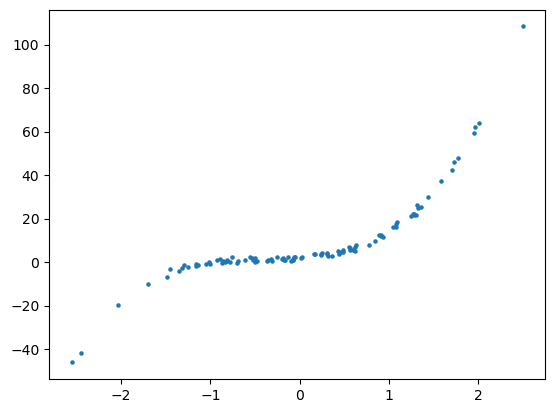

In [44]:
plt.scatter(X, Y, s=5)
plt.show()

## c)

Model with p = 1 variables uses exponents [0, 3]
Model with p = 2 variables uses exponents [0, 3, 4]
Model with p = 3 variables uses exponents [0, 1, 3, 4]
Model with p = 4 variables uses exponents [0, 1, 2, 3, 4]
Model with p = 5 variables uses exponents [0, 1, 2, 3, 4, 5]
Model with p = 6 variables uses exponents [0, 1, 2, 3, 4, 5, 7]
Model with p = 7 variables uses exponents [0, 1, 2, 3, 4, 5, 7, 9]
Model with p = 8 variables uses exponents [0, 1, 2, 3, 4, 5, 6, 7, 9]
Model with p = 9 variables uses exponents [0, 1, 2, 3, 4, 5, 6, 7, 9, 10]
Model with p = 10 variables uses exponents [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


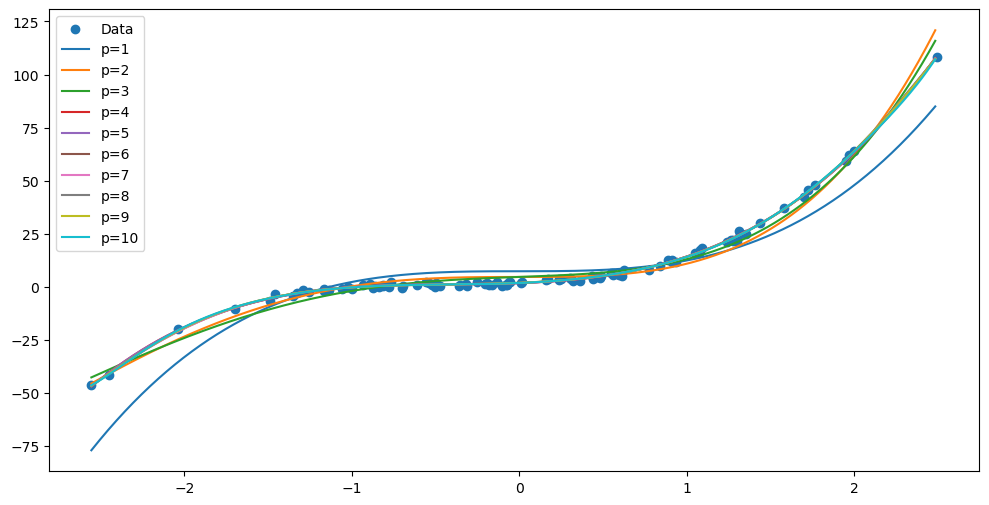

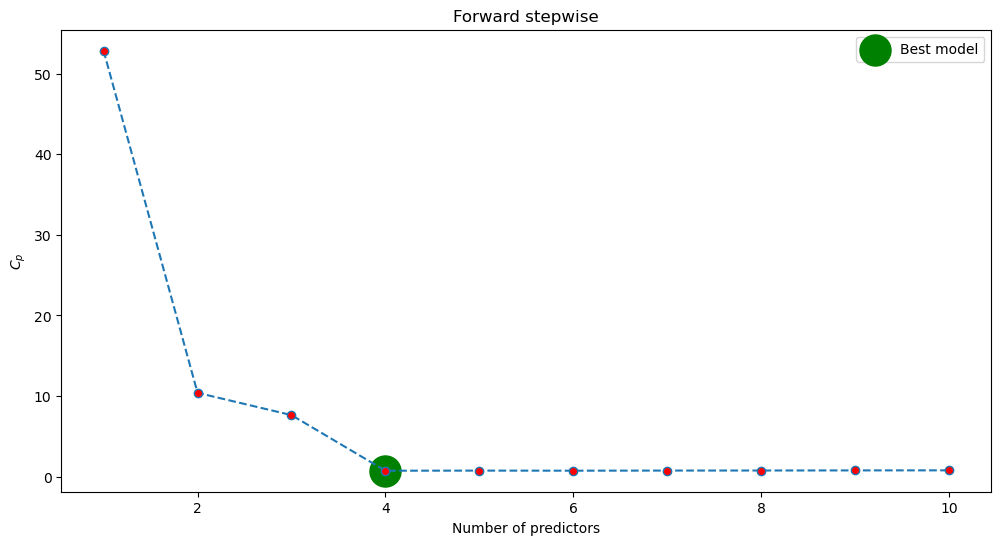

In [45]:
import statsmodels.api as sm

def plot_model(coeffs, exponents, axis):
    X_plot = np.arange(min(X), max(X), 0.01)
    A = np.concatenate([[X_plot**index] for index in exponents], axis=0)
    axis.plot(X_plot, np.dot(coeffs, A), label=f'p={len(coeffs)-1}')
    
def estimate_sigma(Y, X):
    p = 10
    # Fit full model
    A = np.concatenate([[X**i] for i in range(p+1)], axis=0)
    result = sm.OLS(Y, np.transpose(A)).fit()

    # Estimate sigma as RSE
    sigma2 = np.sum((Y - result.predict())**2) / (n - p - 1)
    return sigma2
    
def forward_stepwise(Y, axis):
    model_variables = [np.ones(len(Y))]
    powers_used = {0}
    exponents = [0]
    coeffs = [np.mean(Y)]
    residual = Y - np.dot(coeffs, model_variables)
    Cp = []

    # Estimate sigma2 using all 10 predictors X**i, i = 1,...,10
    # sigma2 = estimate_sigma(Y, X)



    
    
    while len(model_variables) < 11:
        max_product = -1e10
        for i in range(1, 11):
            if i in powers_used:
                continue
            Xi = X**i
            residual_change = np.dot(Xi, residual) / np.linalg.norm(Xi)
            if residual_change > max_product:
                best_index = i
                max_product = residual_change
        model_variables.append(X**best_index)
        exponents.append(best_index)
        powers_used.add(best_index)

        coeffs = sm.OLS(Y, np.transpose(model_variables)).fit().params
        residual = Y - np.dot(coeffs, model_variables)
        current_Cp = np.mean(residual**2) + 2*(len(exponents)-1)*sigma2 / n
        Cp.append(current_Cp) 

        plot_model(coeffs, exponents, axis)

        print(f'Model with p = {len(coeffs)-1} variables uses exponents {sorted(exponents)}')
    return Cp, exponents, coeffs


_, ax = plt.subplots(figsize=(12,6))
ax.scatter(X, Y, label='Data')

# Estimate sigma2 using the true model with X**i, i = 1, 2, 3
sigma2 = sm.OLS(Y, np.transpose(A)).fit().scale
Cp, exponents, coeffs = forward_stepwise(Y, ax)
ax.legend()
plt.show()

_, ax = plt.subplots(figsize=(12,6))
ax.plot(range(1,11), Cp, marker='o', mfc='r', linestyle='--')
min_CP, idx = min(Cp), Cp.index(min(Cp))
ax.scatter(idx+1, min_CP, s=500, c='g', label='Best model')
ax.set_xlabel('Number of predictors')
ax.set_ylabel('$C_p$')
ax.set_title('Forward stepwise')
ax.legend()
plt.show()

            

In [46]:
print(f'Best model is made with {idx+1} predictors, namely\n {sorted(exponents[1:idx+2])}\n')
sorted_indices = list(range(11))
sorted_indices.sort(key = lambda i: exponents[i])
print(f'The coefficients obtained are:')
for i in range(11):
    print(f'beta_{i} = {coeffs[sorted_indices[i]]}')

Best model is made with 4 predictors, namely
 [1, 2, 3, 4]

The coefficients obtained are:
beta_0 = 1.8467206036221595
beta_1 = 3.2687077528342603
beta_2 = 5.4765200999460015
beta_3 = 3.4774755234919024
beta_4 = -0.8403723022412635
beta_5 = 0.4898174253276517
beta_6 = 0.5724390597033953
beta_7 = -0.09082444101739862
beta_8 = -0.13772787807295428
beta_9 = 0.005629162765355439
beta_10 = 0.010458098589439996


## d)

Dropping predictor $X^1$
Dropping predictor $X^3$
Dropping predictor $X^5$
Dropping predictor $X^7$
Dropping predictor $X^9$
Dropping predictor $X^4$
Dropping predictor $X^2$
Dropping predictor $X^6$
Dropping predictor $X^8$
Dropping predictor $X^10$


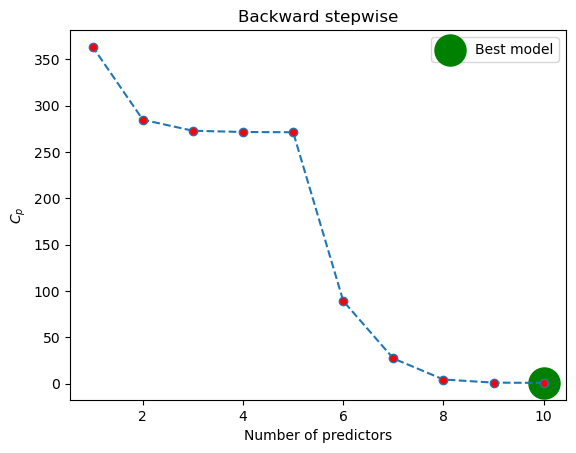

In [47]:
def backward_stepwise(Y, X):
    exponents = list(range(11))
    A = np.concatenate([[X**i] for i in exponents]).T
    Cp = []
    while len(exponents) > 1:
        A_current = A[:,exponents]
        results = sm.OLS(Y, A_current).fit()
        Cp_current = (np.sum((Y - results.predict())**2) + 2*(len(exponents)-1)*sigma2 ) / n
        Cp.append(Cp_current)
        t_values = results.tvalues[1:]
        max_t_value_idx = np.where(abs(t_values) == max(abs(t_values)))[0][0]
        index_to_del = max_t_value_idx + 1
        print(f'Dropping predictor $X^{exponents[index_to_del]}$')

        del exponents[index_to_del]
    return Cp
Cp = backward_stepwise(Y,X)

plt.plot(range(10, 0, -1), Cp, marker='o', linestyle='--', mfc='r')
plt.xlabel('Number of predictors')
plt.ylabel('$C_p$')
plt.title('Backward stepwise')

min_CP, idx = min(Cp), Cp.index(min(Cp))
plt.scatter(10-idx, min_CP, s=500, c='g', label='Best model')
plt.legend()
plt.show()